In [11]:
# ! pip install category_encoders sklearn-pandas tqdm xgboost lightgbm shapash scikit-learn-intelex eli5
# ! pip install -U ipykernel

In [1]:
# from __future__ import print_function
import pandas as pd
import numpy as np
import os
# from google.colab import drive
from tqdm import tqdm
# from joblib import Parallel, delayed
# import re
import math
import re
from string import punctuation

from sklearn.impute import SimpleImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
from sklearn_pandas import DataFrameMapper, gen_features
from category_encoders import OneHotEncoder, OrdinalEncoder
# from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.base import TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearnex import patch_sklearn
# patch_sklearn()

import eli5
import pickle
from time import perf_counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# DRIVE_PATH = '/gdrive/My Drive/Data_Projects/Flu_Shots'
# drive.mount('/gdrive')
# os.chdir(DRIVE_PATH)
# !ls

In [3]:
df_train = pd.read_csv("training_set_features.csv", index_col=0)
labels_train = pd.read_csv("training_set_labels.csv", index_col=0)

In [4]:
df_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
labels_train

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


In [6]:
# df_train = df_train.set_index("respondent_id")
# labels_train = labels_train.set_index("respondent_id")

# Checking if there are inconcistency issues in the data
(df_train.index != labels_train.index).sum()

0

In [7]:
np.testing.assert_array_equal(df_train.index.values, labels_train.index.values)

The assertion ran, and nothing happened. That's good, it means there is no problem. If the two index arrays were not the same, there would be an error.

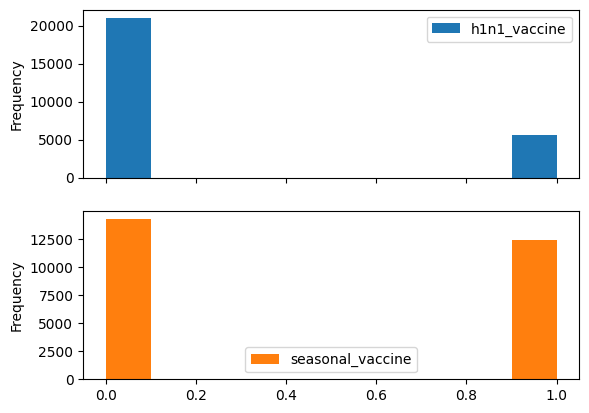

In [8]:
# checking distribution of labels to understand what type of CV split i need

# fig, (ax1, ax2) = plt.subplots(2,1)
# labels_train.h1n1_vaccine.plot(kind='hist', ax=ax1, title='h1n1')
# labels_train.seasonal_vaccine.plot(kind='hist', ax=ax2, title='seasonal')
# fig.tight_layout()
labels_train.plot.hist(subplots = True);

And in simpler terms, let's see the percentage of vaccinated vs unvaccinated for each vaccine type

In [ ]:
perc_h1n1_vaccinated = labels_train['h1n1_vaccine'].sum() / len(labels_train) * 100
perc_seas_vaccinated = labels_train['seasonal_vaccine'].sum() / len(labels_train) * 100

print(f'H1N1 Vaccination percent: {perc_h1n1_vaccinated:2f}%')
print(f'Seasonal Vaccination percent: {perc_seas_vaccinated:2f}%')

H1N1 Vaccination percent: 21.245366%
Seasonal Vaccination percent: 46.560827%


#### Train validation split

In [9]:
# Checking how many observations in test set
# ! wc -l "test_set_features.csv"
! type "test_set_features.csv" | find /c /v ""

26709


Unfortunately, the test set is the same size as the train set.  
So since i can't create a validation set as big, i'll just take a small fraction of the train set for validation

I later decided to use cross validation since the data wasn't that huge<br/>
So no need for train val split

In [10]:
# TRAIN_VAL_RAND_STATE = 1
# TRAIN_VAL_SPLIT = 0.3

# # We use the same train-test split to test all of the models
# df_train_for_val, df_val, labels_train_for_val, labels_val = train_test_split(df_train,
#                                                                               labels_train,
#                                                                               random_state=TRAIN_VAL_RAND_STATE,
#                                                                               test_size=TRAIN_VAL_SPLIT,
#                                                                               shuffle=True)

# print(f"train size: {len(df_train_for_val)}")
# print(f"val size: {len(df_val)}")
# print(f"train labels size: {len(labels_train_for_val)}")
# print(f"val labels size: {len(labels_val)}")

#### Creating functions for testing preprocessors

In [13]:
# def get_columns_after_transform(column_transformer):
#   columns_after_processing = [column for _,_,columns in column_transformer.transformers_ for column in columns]
#   return columns_after_processing

In [14]:
# def pass_through_transformer(df, transformer):
#   df_processed = df.copy()
#   df_processed = transformer.fit_transform(df_processed)

#   columns_after_processing = get_columns_after_transform(transformer)

#   df_processed = pd.DataFrame(df_processed,
#                               columns = columns_after_processing,
#                               index=df.index)
  
#   return df_processed

Making sure i assigned the correct columns to the transformed df  
And that I processed the columns as intended 

In [15]:
def compare_df_row_changes(df_from, df_to):
  '''
    Expects DFs with identical ids and column order!
  '''
  df1 = df_from.copy()
  df2 = df_to.copy()

  ne_stacked = (df1 != df2).stack()
  changed = ne_stacked[ne_stacked]
  changed.index.names = ['id', 'column']

  difference_locations = np.where(df1 != df2)

  changed_from = df1.values[difference_locations]
  changed_to = df2.values[difference_locations]

  print(pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index))

In [16]:
def test_column_transformer(df, data_preparation_pipeline):
  # df_before = df.copy()
  # df_after = pass_through_transformer(df_before, transformer)

  # columns_after_processing = get_columns_after_transform(transformer)

  # df1 = df_before[columns_after_processing].iloc[[0,1], :]
  # df2 = df_after.iloc[[0,1], :]
  df_before  = df.copy()
  df_after = data_preparation_pipeline.fit_transform(df_before)

  df_before_compared = df_before[df_after.columns].iloc[[0,1], :]
  df_after_compared = df_after.iloc[[0,1], :]

  compare_df_row_changes(df_before_compared, df_after_compared)

In [17]:
def describe_columns(df):
  TOO_MANY_NULLS_PERCENT = 0.01
  columns_with_lots_of_nulls = []

  print(f"The df has {df.shape[1]} columns")
  print("Column name                  | dtype   | Amount of nulls")
  print("--------------------------------------------------------")
  for column in df.columns:
    num_of_nulls = df[column].isnull().sum()
    col_dtype = str(df.dtypes[column])
    print(f"{column:<28} | {col_dtype:<7} | {num_of_nulls}")

    if num_of_nulls > len(df_train) * TOO_MANY_NULLS_PERCENT:
      columns_with_lots_of_nulls.append(column)

  print()
  print(f"Columns that have more than {TOO_MANY_NULLS_PERCENT * 100}% null values:")
  print(columns_with_lots_of_nulls)

describe_columns(df_train)

The df has 35 columns
Column name                  | dtype   | Amount of nulls
--------------------------------------------------------
h1n1_concern                 | float64 | 92
h1n1_knowledge               | float64 | 116
behavioral_antiviral_meds    | float64 | 71
behavioral_avoidance         | float64 | 208
behavioral_face_mask         | float64 | 19
behavioral_wash_hands        | float64 | 42
behavioral_large_gatherings  | float64 | 87
behavioral_outside_home      | float64 | 82
behavioral_touch_face        | float64 | 128
doctor_recc_h1n1             | float64 | 2160
doctor_recc_seasonal         | float64 | 2160
chronic_med_condition        | float64 | 971
child_under_6_months         | float64 | 820
health_worker                | float64 | 804
health_insurance             | float64 | 12274
opinion_h1n1_vacc_effective  | float64 | 391
opinion_h1n1_risk            | float64 | 388
opinion_h1n1_sick_from_vacc  | float64 | 395
opinion_seas_vacc_effective  | float64 | 462
opinion_sea

#### Checking for bad values

In [18]:
for column in df_train.columns:
    print(column)
    print(df_train[column].unique())

h1n1_concern
[ 1.  3.  2.  0. nan]
h1n1_knowledge
[ 0.  2.  1. nan]
behavioral_antiviral_meds
[ 0.  1. nan]
behavioral_avoidance
[ 0.  1. nan]
behavioral_face_mask
[ 0.  1. nan]
behavioral_wash_hands
[ 0.  1. nan]
behavioral_large_gatherings
[ 0.  1. nan]
behavioral_outside_home
[ 1.  0. nan]
behavioral_touch_face
[ 1.  0. nan]
doctor_recc_h1n1
[ 0. nan  1.]
doctor_recc_seasonal
[ 0. nan  1.]
chronic_med_condition
[ 0.  1. nan]
child_under_6_months
[ 0.  1. nan]
health_worker
[ 0.  1. nan]
health_insurance
[ 1. nan  0.]
opinion_h1n1_vacc_effective
[ 3.  5.  4.  2.  1. nan]
opinion_h1n1_risk
[ 1.  4.  3.  2.  5. nan]
opinion_h1n1_sick_from_vacc
[ 2.  4.  1.  5.  3. nan]
opinion_seas_vacc_effective
[ 2.  4.  5.  3.  1. nan]
opinion_seas_risk
[ 1.  2.  4.  3.  5. nan]
opinion_seas_sick_from_vacc
[ 2.  4.  1.  5. nan  3.]
age_group
['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
education
['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
race
['

As ususal for training competition data, the values are squeaky clean

### Handling nulls

In [19]:
columns_with_type_float = df_train.select_dtypes(include=['float64']).columns.tolist()
columns_with_type_string = df_train.select_dtypes(include=['object']).columns.tolist()

#### Float64 Features 

100%|██████████| 23/23 [00:00<00:00, 24.41it/s]


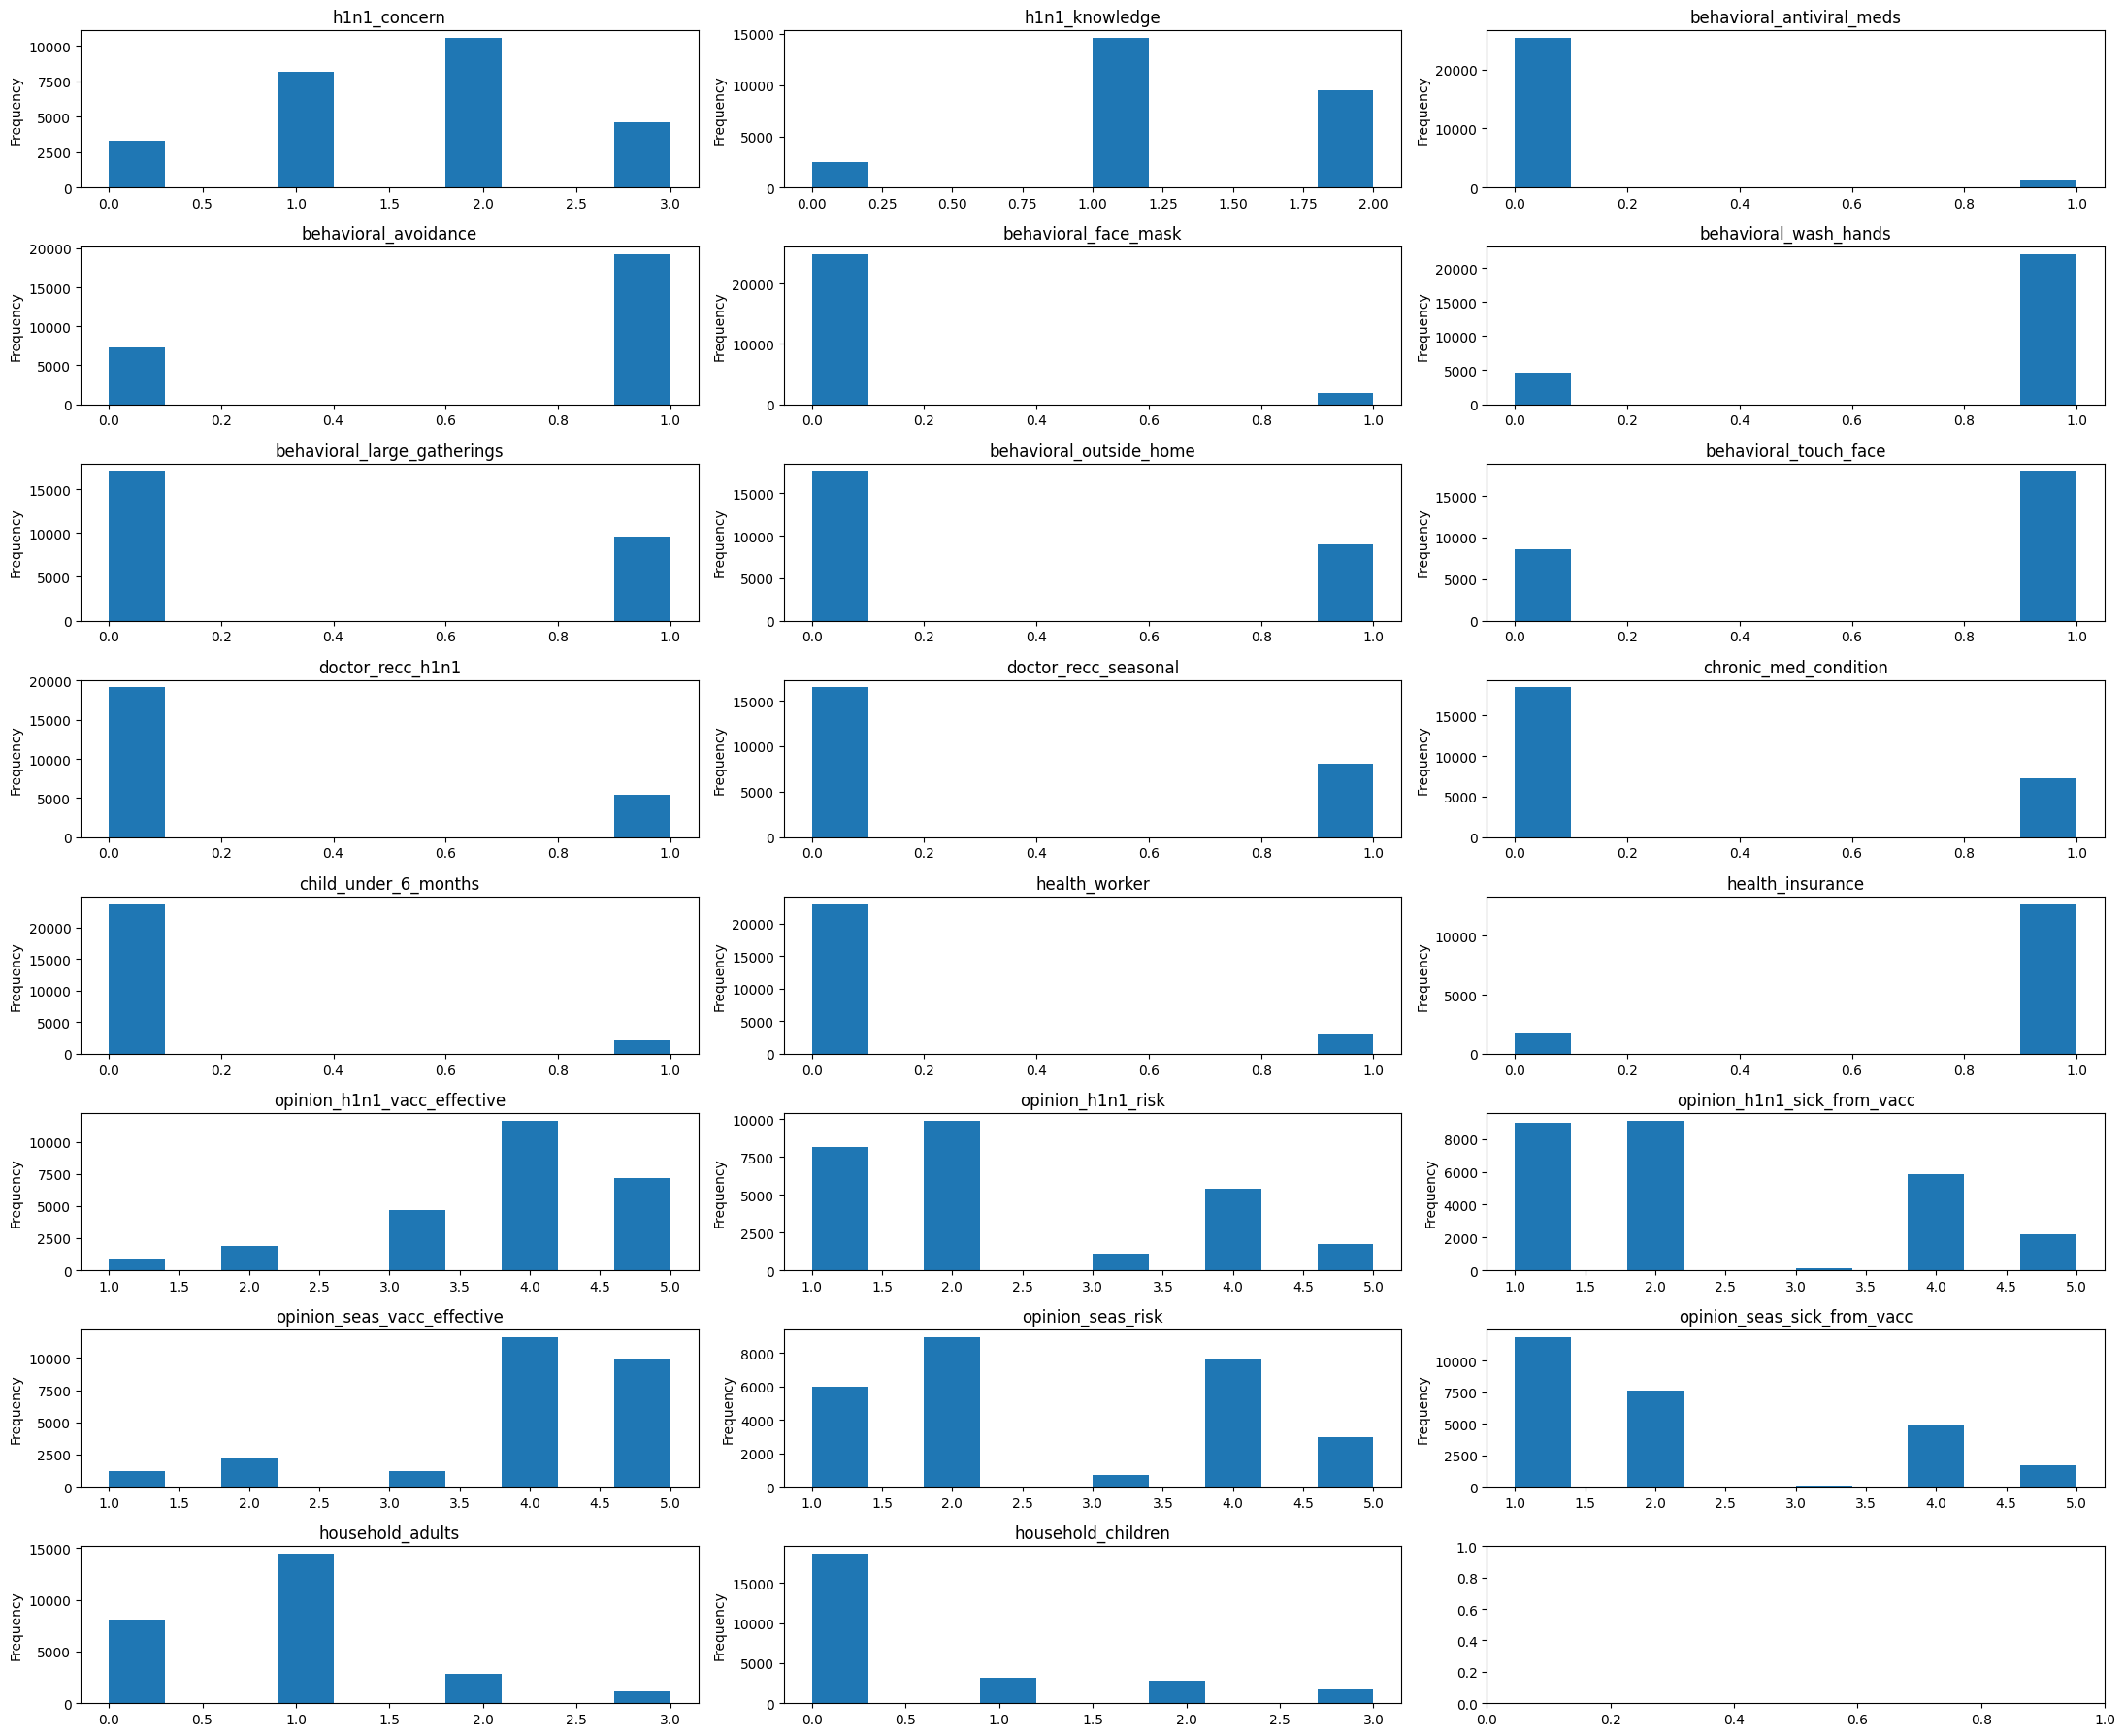

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(22,18))
axes_list = [item for sublist in axes for item in sublist] 

# plot every month's daily count of transactions
for column in tqdm(columns_with_type_float):
  ax = axes_list.pop(0)
  df_train[column].plot(kind='hist', ax=ax)
  ax.set_title(column)

fig.tight_layout()

In [21]:
# columns_that_can_have_better_impute = ['doctor_recc_h1n1', # X
#                                        'doctor_recc_seasonal', # X
#                                        'health_insurance', # V
#                                        'education', # 
#                                        'income_poverty',
#                                        'marital_status',
#                                        'rent_or_own',
#                                        'employment_status', 
#                                        'employment_industry',
#                                        'employment_occupation']


In [22]:
features_to_not_impute = {'respondent_id'}

# for now i'll impute the doctor_recc features with most freq values
# mostly because a placeholder value is too much of a hassle for a temporary setup
float_features_for_placeholder_impute = set()
# float_features_for_placeholder_impute = {'doctor_recc_h1n1',
#                                          'doctor_recc_seasonal'}

# Since all the data is categorical, all the features will be MF imputed by default 
# Feautures that need to be specially imputed are the odd ones
# And i'll explicitly take them out of the default list
all_float_features = set(df_train.select_dtypes(include=['float64']).columns)

float_features_for_mf_impute =  all_float_features \
 - float_features_for_placeholder_impute \
 - features_to_not_impute

float_features_to_preprocess = float_features_for_mf_impute | float_features_for_placeholder_impute

#### String Categorical Features

100%|██████████| 12/12 [00:00<00:00, 32.18it/s]


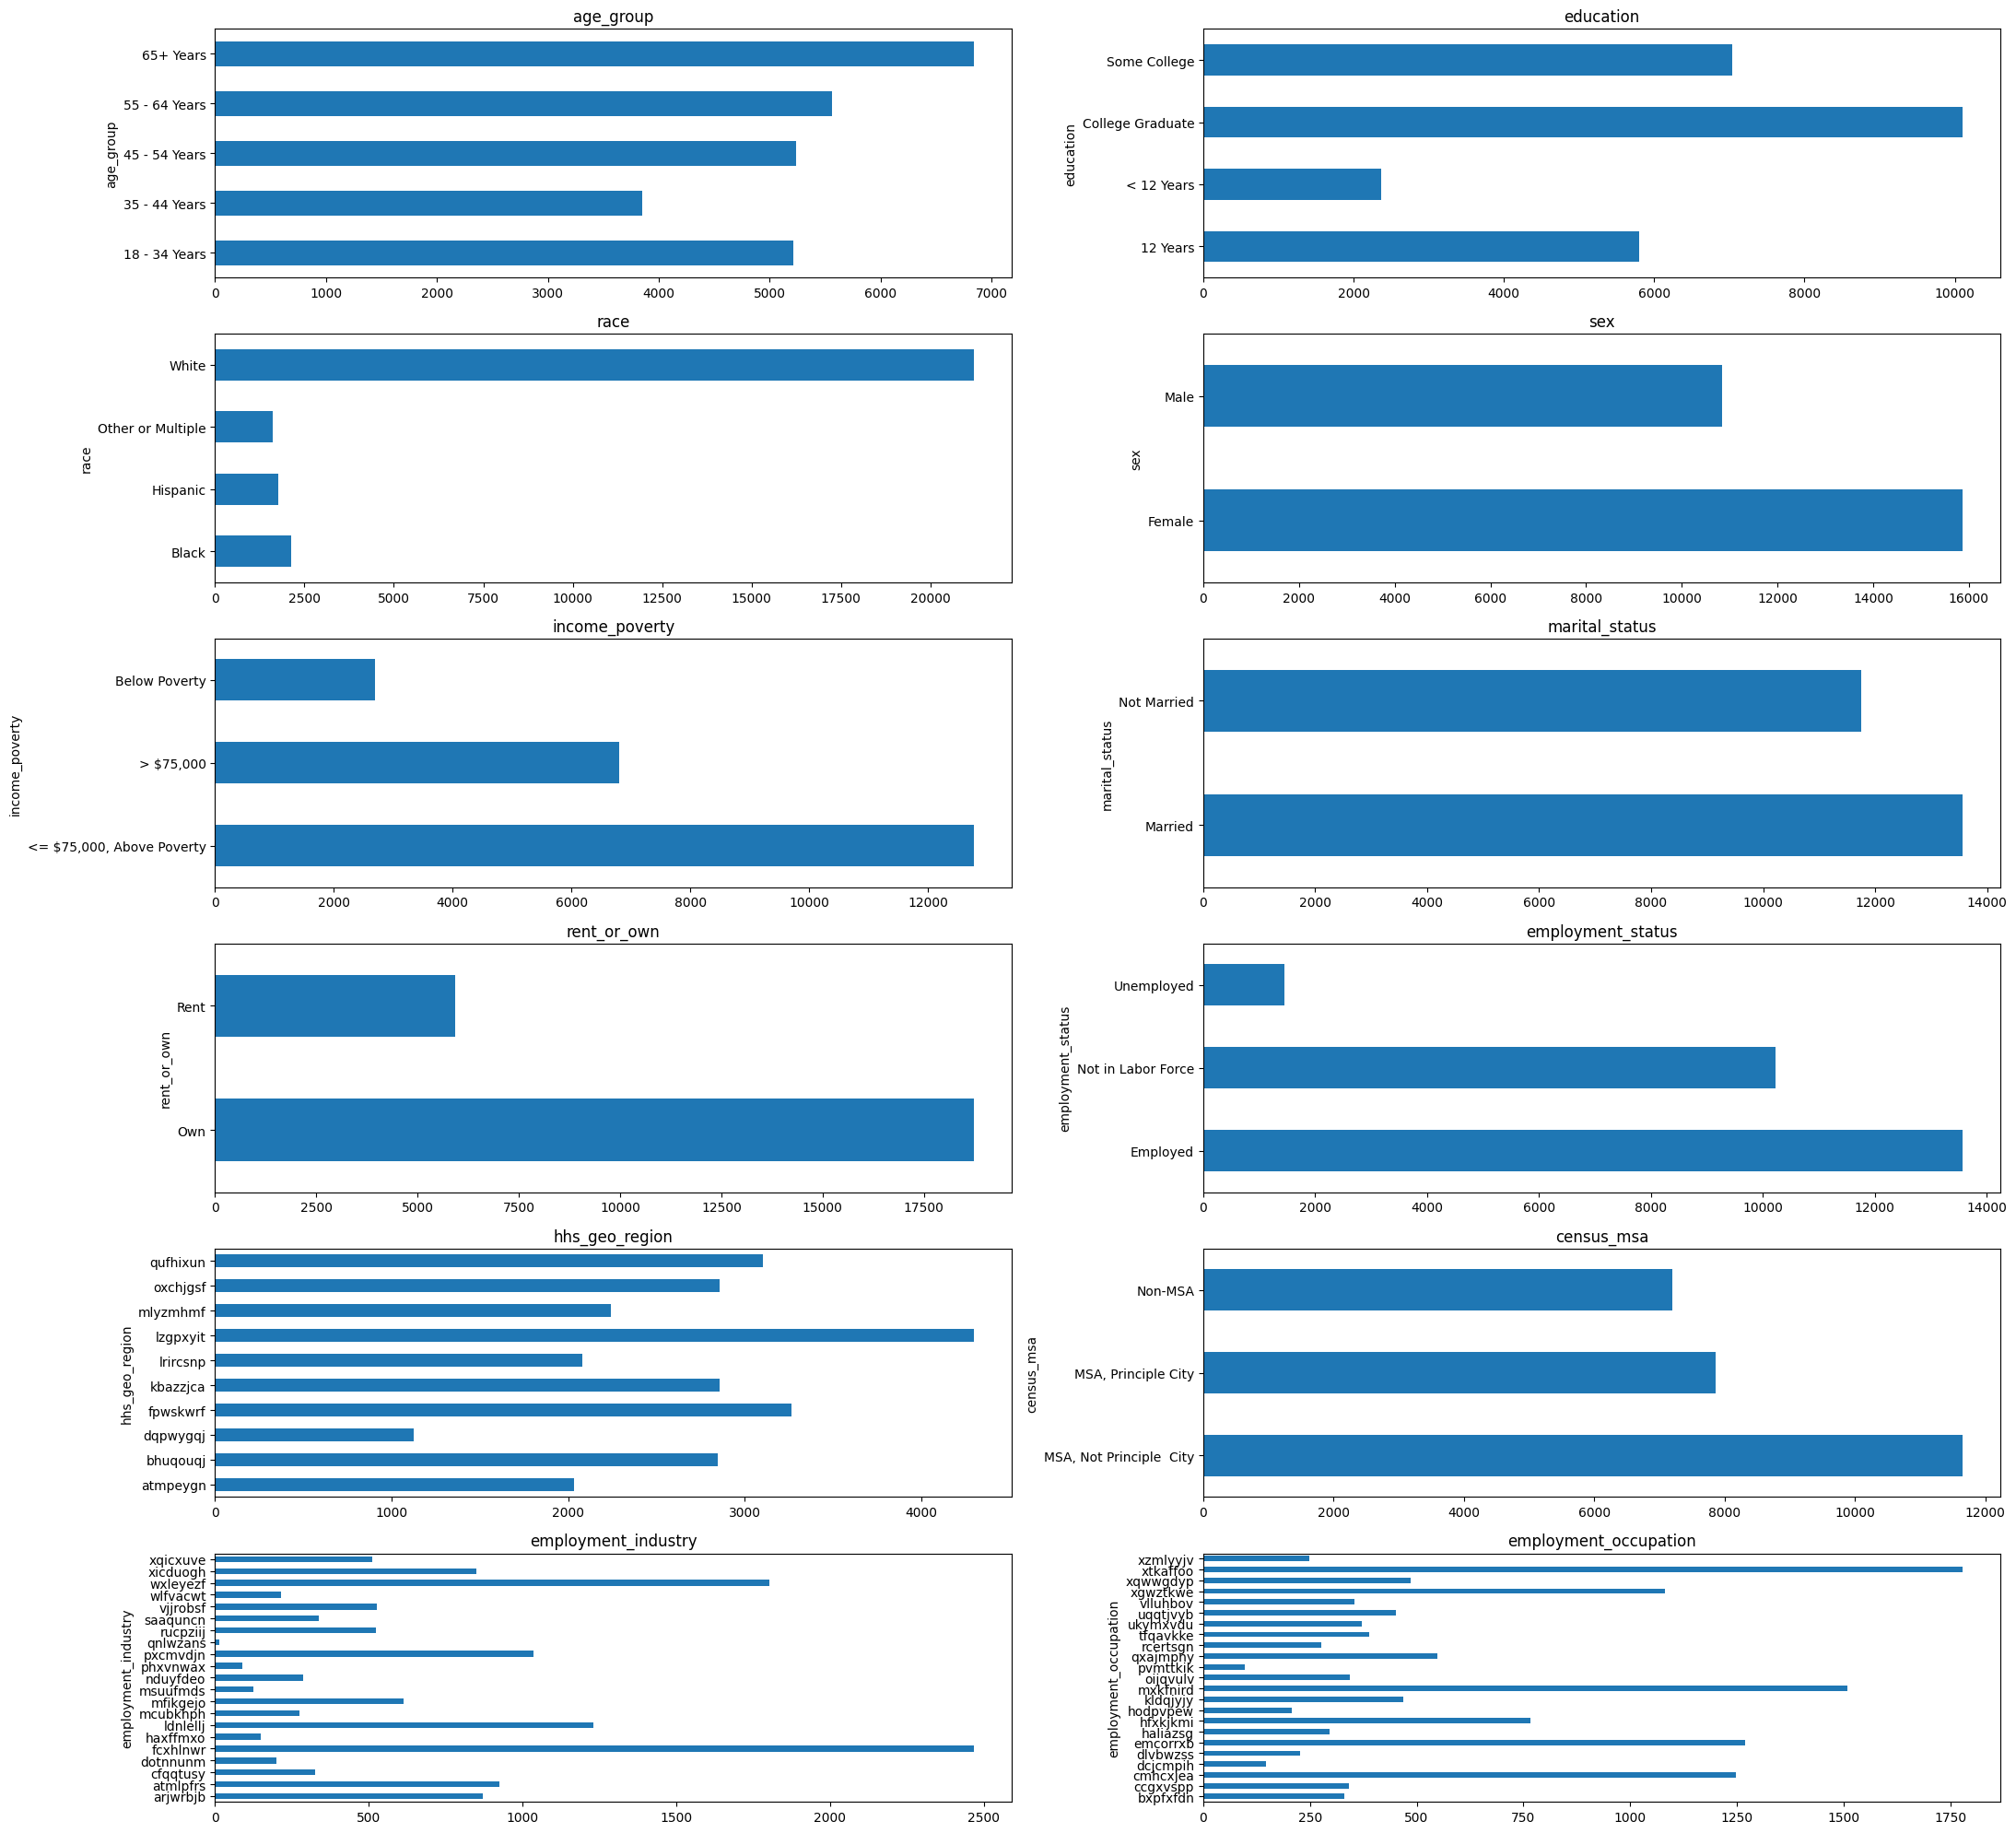

In [23]:
PLOTS_PER_ROW = 2
n_rows = math.ceil(len(columns_with_type_string) / PLOTS_PER_ROW)
fig, axes = plt.subplots(ncols=PLOTS_PER_ROW, nrows=n_rows, figsize=(22,20))
axes_list = [column for row in axes for column in row] 

# plot every feature's frequency of each value
for column in tqdm(columns_with_type_string):
  ax = axes_list.pop(0)
  df_train.groupby(column).size().plot.barh(title=column, ax=ax)

fig.tight_layout()

Since I don't want to start fiddling with Advanced imputation techniques, for now I'll only impute `race` and `rent_or_own` using the most frequent value, and all the rest of the features will simply have a literal string `NaN` where empty so I could still get some sense of which features are useful for this classification

In [24]:
string_features_for_mf_impute = { 'race', 'rent_or_own' }
string_features_for_placeholder_impute = set(columns_with_type_string) - string_features_for_mf_impute
string_features_to_preprocess = string_features_for_mf_impute | string_features_for_placeholder_impute

#### Imputation

In [25]:
df_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [26]:
features_for_mf_impute = float_features_for_mf_impute | string_features_for_mf_impute
features_for_placeholder_impute = float_features_for_placeholder_impute | string_features_for_placeholder_impute

features_for_mf_impute_for_DfMapper = [[feature] for feature in features_for_mf_impute]
features_for_placeholder_impute_for_DfMapper = [[feature] for feature in features_for_placeholder_impute]

# most_freq_imputer = SimpleImputer(strategy='most_frequent')
# placeholder_imputer = SimpleImputer(strategy='constant', fill_value='NaN')

# data_preparation_imputer = ColumnTransformer([
#                                               ('mf', most_freq_imputer, features_for_mf_impute),
#                                               ('nan', placeholder_imputer, features_for_placeholder_impute)
# ])

feature_def_for_mf_impute = gen_features(
    columns = features_for_mf_impute_for_DfMapper,
    classes = [{'class': SimpleImputer, 'strategy':'most_frequent'}]
)
feature_def_for_placeholder_impute = gen_features(
    columns = features_for_placeholder_impute_for_DfMapper,
    classes = [{'class': SimpleImputer, 'strategy':'constant', 'fill_value': 'NaN'}]
)
feature_def_for_impute = feature_def_for_mf_impute + feature_def_for_placeholder_impute

data_preparation_imputer = DataFrameMapper(feature_def_for_impute, df_out=True)

data_preparation_pipeline = Pipeline([('Impute', data_preparation_imputer)])

In [27]:
FEATURES_TO_PREPROCESS = float_features_to_preprocess | string_features_to_preprocess
df_train_for_preprocess = df_train[FEATURES_TO_PREPROCESS]

In [28]:
test_column_transformer(df_train_for_preprocess, data_preparation_imputer)

                         from   to
id column                         
0  employment_industry    NaN  NaN
   employment_occupation  NaN  NaN


### Encoding string columns

In [29]:
df_train_for_preprocess = data_preparation_imputer.fit_transform(df_train_for_preprocess)

#### Handling categories with order

##############################################  
TBD: Handle bad NaNs with advanced imputers 
##############################################

In [30]:
ORDERED_CATEGORIES_MAPPING = [
    {'col' : 'age_group', 'mapping' : {'18 - 34 Years' : 0,
                                       '35 - 44 Years' : 1,
                                       '45 - 54 Years' : 2,
                                       '55 - 64 Years' : 3,
                                       '65+ Years' : 4 }}, 
    {'col' : 'education', 'mapping' : {'NaN' : 0, ########################################
                                       '< 12 Years' : 1,
                                       '12 Years' : 2,
                                       'Some College' : 3,
                                       'College Graduate' : 4}}, 
    {'col' : 'income_poverty', 'mapping' : {'NaN': 0, ########################################
                                            'Below Poverty' : 1,
                                            '<= $75,000, Above Poverty' : 2,
                                            '> $75,000' : 3}}
]

string_features_for_ordered_encode = {column_mapping['col'] for column_mapping in ORDERED_CATEGORIES_MAPPING}

In [31]:
#################################################################################
# for some annoying reason, ordinal encoder expects a list of categories to convert at once
# So i'll try to pass all the categories into a single transformer in the ctf 
# and will have to make sure they'll come out the same with regards to order and everything
#################################################################################
# age_group_oe = OrdinalEncoder(categories = [ORDERED_CATEGORIES['age_group'], ORDERED_CATEGORIES['education']])
# age_group_oe.fit_transform(df_train_for_preprocess[['age_group', 'education']])

#### Checking which categories can be OneHot encoded

In [32]:
for feature in string_features_to_preprocess:
  print(f'{feature}\'s Cardinality is {df_train[feature].nunique()}')

hhs_geo_region's Cardinality is 10
sex's Cardinality is 2
marital_status's Cardinality is 2
rent_or_own's Cardinality is 2
education's Cardinality is 4
employment_industry's Cardinality is 21
employment_occupation's Cardinality is 23
income_poverty's Cardinality is 3
race's Cardinality is 4
census_msa's Cardinality is 3
employment_status's Cardinality is 3
age_group's Cardinality is 5


##############################################  
TBD: Handle bad NaNs with advanced imputers 
##############################################

Looks like 5 is a decent limit of cardinality for choosing which features will be OH encoded

In [33]:
CARDINALITY_LIMIT = 5

string_features_for_OH_encode = {
    feature for feature in string_features_to_preprocess 
    if (df_train[feature].nunique() <= CARDINALITY_LIMIT)
        and (feature not in string_features_for_ordered_encode)
    }

#### All non ordered or non OHed will just be encoded using a plain ordinal encoder

In [34]:
string_features_for_plain_encode = string_features_to_preprocess - \
                                  string_features_for_ordered_encode - \
                                  string_features_for_OH_encode

#### Building Categorical encoding pipeline

In [35]:
##############################################################
# Either I use this columntransformer and lose column names
##############################################################
# category_encoder = ColumnTransformer([
#                                     ('ordered', ordered_encoder, list(string_features_for_ordered_encode)),
#                                     # ('one_hot', OneHotEncoder(sparse=False), list(string_features_for_OH_encode)),
#                                     ('one_hot', ohe(use_cat_names=True), list(string_features_for_OH_encode)),
#                                     ('plain_encode', OrdinalEncoder(), list(string_features_for_plain_encode))
# ])

# category_encoder.fit_transform(df_train_for_preprocess)
# # Cannot be tested by my func since OH creates more columns than the original df
# test_column_transformer(df_train_for_preprocess[string_features_for_ordered_encode | string_features_for_plain_encode], category_encoder)

##############################################################
# Or i use the sklearn_pandas.DataFrameMapper for imputing to preserve column names
# So i could find the best columns later.

# In any case, i'll assume the pipeline still gets DFs with column names at this stage
##############################################################
ordered_encoder = OrdinalEncoder(cols = string_features_for_ordered_encode, mapping = ORDERED_CATEGORIES_MAPPING)
oh_encoder = OneHotEncoder(cols = string_features_for_OH_encode, use_cat_names=True)
plain_encoder = OrdinalEncoder(cols = string_features_for_plain_encode)

data_preparation_pipeline.steps.append(('ordered_enc', ordered_encoder))
data_preparation_pipeline.steps.append(('OH_enc', oh_encoder))
data_preparation_pipeline.steps.append(('plain_enc', plain_encoder))
    

#### Changing categories' values to only contain [A-Za-z0-9_] 

Encoders put the category name in a new field (e.g. "age_group_18 - 43 Years")  
And some classifiers (ahem lightGBM) accept field names only with \w characters

So I created a transformer that converts all non \w characters to special words that can be retranslated later

In [36]:
class LGBMCategoryNameEncoder(TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
        self.conversion_dict = dict()
        for punct in punctuation:
            self.conversion_dict[punct] = '__' + str(ord(punct)) + '__'
        self.conversion_dict.pop('_')
        self.conversion_dict[' '] = '_SPACE_'
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_X = X.copy()
        new_columns = new_X.columns
        for punct, punct_replacment in self.conversion_dict.items():
            new_columns = [column_name.replace(punct, punct_replacment) for column_name in new_columns]
        
        new_X.columns = new_columns
        return new_X

# H1N1 shots
I want to handle each problem orthonogically. After I'll feel I know enough about H1N1 predictions, I'll start working on improving flu shot scores as well.

## Testing Models

In [5]:
MODELS_FOLDER = './models'

def save_model_pipeline_and_info(model_pipe_and_info, file_name):
  full_path = os.path.join(MODELS_FOLDER, file_name)
  with open(full_path, 'wb') as model_pipeline_and_info_file:
    pickle.dump(model_pipe_and_info, model_pipeline_and_info_file)
            
def get_model_pipeline_and_info(file_name):
  full_path = os.path.join(MODELS_FOLDER, file_name)
  if os.path.exists(full_path):
    with open(full_path, 'rb') as model_pipeline_and_info_file:
      model_pipe_and_info = pickle.load(model_pipeline_and_info_file)
  else:
      return None
  return model_pipe_and_info

In [38]:
global best_model_so_far

old_best_model_so_far = get_model_pipeline_and_info(file_name='best_model_so_far.pickle')
if old_best_model_so_far is not None:  
  best_model_so_far = dict(old_best_model_so_far) 
  dict_of_fame = {
    old_best_model_so_far['name'] : old_best_model_so_far['scores']
    }
else:
  dict_of_fame = {}
  best_model_so_far = None

In [39]:
# EVAL_METRIC = 'auc'
# EARLY_STOP_EVAL_SET = df_val_for_clf
SCORE_IMPROVEMENT_MARGIN = 0.01

def is_model_fame_worthy(scores):
  global best_model_so_far
  if best_model_so_far:
    return scores.mean() >= (best_model_so_far['scores']['validation'].mean() + SCORE_IMPROVEMENT_MARGIN)
  else:
    return True

In [40]:
def report_fit_time(fit_start, fit_end):
  # Calculate the current model's performance and time
  # fit time is in seconds
  fit_time = fit_end - fit_start
  fit_time_hours = int(fit_time / 60 / 60)
  fit_time_minutes = int(fit_time / 60 )
  fit_time_seconds = int(fit_time % 60)

  print("Cross Validation time: {} hours, {} minutes, {} seconds".format(fit_time_hours, fit_time_minutes, fit_time_seconds))
  return fit_time

#### Classifiers

In [41]:
model_pipes_to_evaluate = dict()

##### Logistic Regressor

In [42]:
model = LogisticRegression(C=1, n_jobs=-1, verbose=False)
model_name = 'Simple Logit Regressor'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### SVM

In [43]:
model = SVC(verbose=False)
model_name = 'Simple SVM classifier'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### Random Forest

In [44]:
model = RandomForestClassifier(n_jobs=-1, verbose=False)
model_name = 'Simple Random Forest'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### XGBoost

In [45]:
model_name = 'Guessed HyperParams XGBClassifier'
model = XGBClassifier(objective = 'binary:logistic',
                     n_estimators = 1000,
                     learning_rate = 0.01,
                     n_jobs = -1) # ,
                    #  tree_method = 'gpu_hist')
fit_params = {
    # model_name + '__early_stopping_rounds' : 30,
    # model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    # model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### LightGBM

In [46]:
model_name = 'Guessed HyperParams LightGBM'
model = LGBMClassifier(n_estimators=1000, n_jobs=-1, objective='binary')
fit_params = {
    # model_name + '__early_stopping_rounds' : 30,
    # model_name + '__eval_set' : EARLY_STOP_EVAL_SET,
    # model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose': False
}

pipeline = Pipeline([
    ('preprocess', data_preparation_pipeline),
    ('Standardize Column Names', LGBMCategoryNameEncoder()),
    (model_name, model)
])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))


#### And for the results:

In [47]:
overall_train_cv_scoreboard = pd.DataFrame()
overall_val_cv_scoreboard = pd.DataFrame()

In [48]:
float_features_to_classify_by = float_features_to_preprocess
string_features_to_classify_by = string_features_to_preprocess

FEATURES_TO_CLASSIFY_BY = float_features_to_classify_by | string_features_to_classify_by
df_train_for_clf = df_train[FEATURES_TO_CLASSIFY_BY]
labels_train_for_clf = labels_train['h1n1_vaccine']

# I planned to use a simple train val split, but ended up deciding i can even use cross validation here
# df_val_for_clf = df_val[FEATURES_TO_CLASSIFY_BY]
# labels_val_for_clf = labels_val['h1n1_vaccine']

In [70]:
CROSS_VALIDATOR = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

def evaluate_model_pipelines(model_pipelines):
  train_cv_scoreboard = pd.DataFrame()
  val_cv_scoreboard = pd.DataFrame()

  for name, (model_pipeline, fit_params) in tqdm(model_pipelines.items()):
    print('\n###########################################################################')
    print('# Model type: {}'.format(name))
    print('###########################################################################')
    
    # Train the model
    fit_start = perf_counter()
    cv_scores = cross_validate(model_pipeline, df_train_for_clf, labels_train_for_clf,
                            fit_params = fit_params,
                            cv=CROSS_VALIDATOR,
                            n_jobs = -1,
                            scoring='roc_auc',
                            return_train_score=True)
    fit_end = perf_counter()

    print()
    fit_time = report_fit_time(fit_start, fit_end)
    
    # plot_model_performance(model_history)
    # train_predictions = model_pipeline.predict(df_train_for_clf)
    # val_predictions = model_pipeline.predict(df_val_for_clf)
    # test_predictions = model_pipeline.predict(df_test_for_clf)

    train_cv_scoreboard[name] = cv_scores['train_score']
    val_cv_scoreboard[name] = cv_scores['test_score']
        
    # scores = {
    #     'Training' : cv_scores['train_score'].mean(),
    #     'Validation' : cv_scores['test_score'].mean()
    #     # 'Test' : accuracy_score(labels_test_for_clf, test_predictions)
    #     }

    # for dataset_name, score in scores.items():
      # print ("%s auc: %0.5f " % (dataset_name, score))  
    # print(f'''Training:
    # Mean Score: {cv_scores['train_score'].mean()}
    # Score Standad Deviation: {cv_scores['train_score'].std()}''')

    # print(f'''Validation:
    # Mean Score: {cv_scores['test_score'].mean()}
    # Score Standad Deviation: {cv_scores['test_score'].std()}''')

    if is_model_fame_worthy(val_cv_scoreboard[name]):
      model_pipeline.fit(df_train_for_clf, labels_train_for_clf, **fit_params)

      global best_model_so_far
      best_model_so_far = {
          'name' : name, # Name of the model
          'pipeline_and_params' : (model_pipeline, fit_params), # A tuple containing a sklearn.Pipeline object and a parameters dict
          'scores' : {
              'train' : train_cv_scoreboard[name],
              'validation' : val_cv_scoreboard[name]
          }, # The cv scores of the model
          'time' : fit_time # Training time in seconds
          }
      dict_of_fame[name] = best_model_so_far['scores']

  print()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print('@ Best models roundup')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  for name, score in dict_of_fame.items():
    print(f'Name: {name}\n Scores: {score}')

  train_cv_scoreboard['Best So Far'] = best_model_so_far['scores']['train']
  val_cv_scoreboard['Best So Far'] = best_model_so_far['scores']['validation']
  
  return train_cv_scoreboard, val_cv_scoreboard

train_cv_scoreboard, val_cv_scoreboard = evaluate_model_pipelines(model_pipes_to_evaluate)

  0%|          | 0/5 [00:00<?, ?it/s]


###########################################################################
# Model type: Simple Logit Regressor
###########################################################################


 20%|██        | 1/5 [00:03<00:13,  3.31s/it]


Cross Validation time: 0 hours, 0 minutes, 3 seconds

###########################################################################
# Model type: Simple SVM classifier
###########################################################################


 40%|████      | 2/5 [02:11<03:50, 76.78s/it]


Cross Validation time: 0 hours, 2 minutes, 8 seconds

###########################################################################
# Model type: Simple Random Forest
###########################################################################


 60%|██████    | 3/5 [02:17<01:28, 44.30s/it]


Cross Validation time: 0 hours, 0 minutes, 5 seconds

###########################################################################
# Model type: Guessed HyperParams XGBClassifier
###########################################################################


 80%|████████  | 4/5 [03:40<00:59, 59.72s/it]


Cross Validation time: 0 hours, 1 minutes, 23 seconds

###########################################################################
# Model type: Guessed HyperParams LightGBM
###########################################################################


100%|██████████| 5/5 [03:51<00:00, 46.22s/it]


Cross Validation time: 0 hours, 0 minutes, 10 seconds

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@ Best models roundup
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Name: Guessed HyperParams XGBClassifier
 Scores: {'train': 0    0.907312
1    0.907068
2    0.908829
3    0.908840
4    0.907546
Name: Guessed HyperParams XGBClassifier, dtype: float64, 'validation': 0    0.837579
1    0.843970
2    0.835417
3    0.842397
4    0.843620
Name: Guessed HyperParams XGBClassifier, dtype: float64}


In [71]:
overall_train_cv_scoreboard = pd.concat([overall_train_cv_scoreboard, train_cv_scoreboard])
overall_val_cv_scoreboard = pd.concat([overall_val_cv_scoreboard, val_cv_scoreboard])

In [50]:
# best_model_so_far = {
#           'name' : 'Guessed HyperParams XGBClassifier', # Name of the model
#           'pipeline_and_params' : best_model_so_far['pipeline_and_params'], # A tuple containing a sklearn.Pipeline object and a parameters dict
#           'scores' : {
#               'train' : train_cv_scoreboard['Guessed HyperParams XGBClassifier'],
#               'validation' : val_cv_scoreboard['Guessed HyperParams XGBClassifier']
#           }, # The cv scores of the model
#           'time' : best_model_so_far['time'] # Training time in seconds
#           }

<AxesSubplot:title={'center':'validation scores'}>

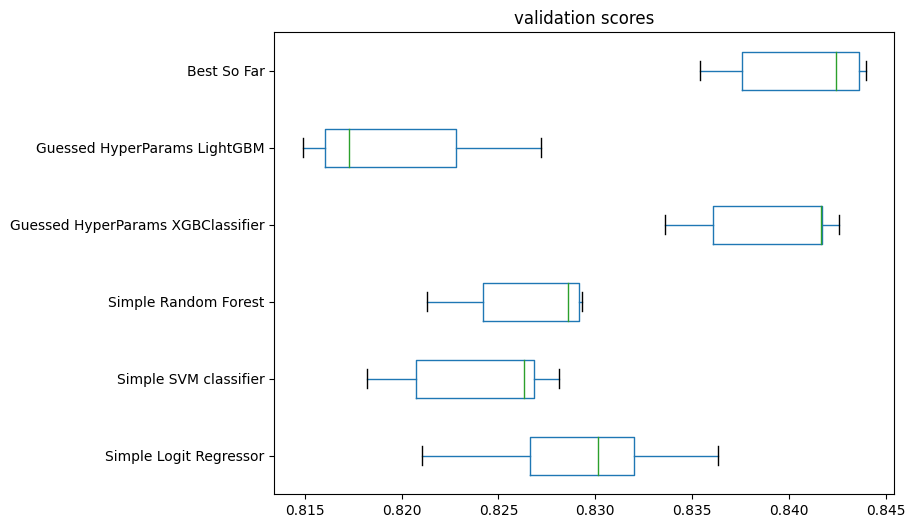

In [51]:
overall_val_cv_scoreboard.plot(kind='box', title='validation scores', figsize = (8,6), vert=False)

In [52]:
save_model_pipeline_and_info(best_model_so_far, file_name='best_model_so_far.pickle')
best_model_so_far

{'name': 'Guessed HyperParams XGBClassifier',
 'pipeline_and_params': (Pipeline(steps=[('preprocess',
                   Pipeline(steps=[('Impute',
                                    DataFrameMapper(df_out=True, drop_cols=[],
                                                    features=[(['behavioral_large_gatherings'],
                                                               TransformerPipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent'))]),
                                                               {}),
                                                              (['behavioral_antiviral_meds'],
                                                               TransformerPipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent'))]),
                             

### Now running only on selected features

#### Selecting Best Features

Running all the data preprocess pipeline so far at once as a quick integration test for the preprocessing so far

In [40]:
df_train_for_preprocess = data_preparation_pipeline.fit_transform(df_train[FEATURES_TO_PREPROCESS])

Feature behavioral_face_mask: 123.284462
Feature opinion_seas_vacc_effective: 243.320341
Feature health_worker: 672.405011
Feature behavioral_antiviral_meds: 41.109698
Feature opinion_h1n1_risk: 1914.151226
Feature rent_or_own_Own: 5.689314
Feature rent_or_own_Rent: 19.938027
Feature race_White: 5.232609
Feature race_Black: 51.410561
Feature race_Other or Multiple: 0.157839
Feature race_Hispanic: 0.210187
Feature h1n1_knowledge: 111.808117
Feature behavioral_avoidance: 15.950408
Feature child_under_6_months: 109.342915
Feature opinion_h1n1_vacc_effective: 495.639893
Feature opinion_h1n1_sick_from_vacc: 115.654361
Feature behavioral_large_gatherings: 5.614840
Feature health_insurance: 3.046439
Feature h1n1_concern: 201.358892
Feature opinion_seas_sick_from_vacc: 2.015818
Feature doctor_recc_seasonal: 892.499456
Feature behavioral_wash_hands: 25.856864
Feature chronic_med_condition: 172.886102
Feature household_children: 0.284434
Feature opinion_seas_risk: 1222.319922
Feature behavioral_

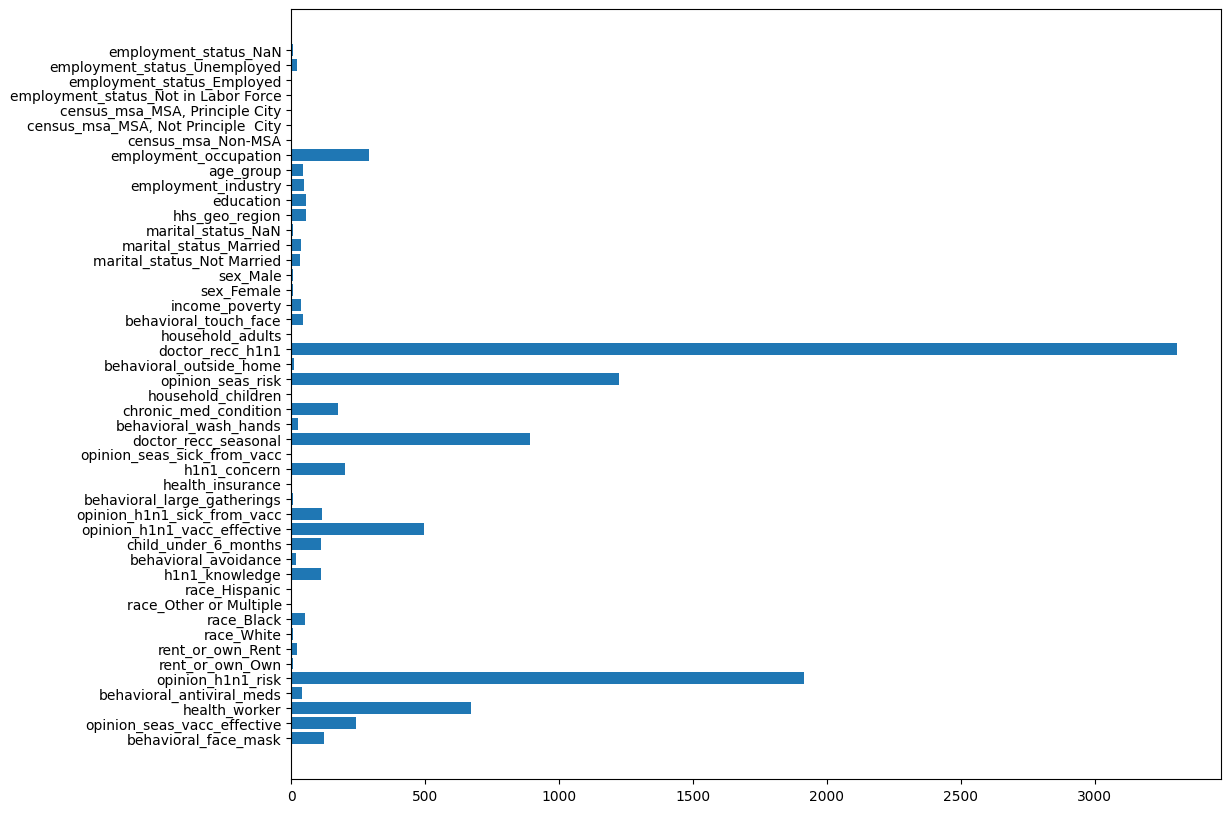

In [41]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(df_train_for_preprocess, labels_train['h1n1_vaccine'])

columns = df_train_for_preprocess.columns
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()

In [42]:
# Only here to show the graph above is correct with column assigments
fs_top_features = SelectKBest(score_func=chi2, k=4)

fs_top_features.fit(df_train_for_preprocess, labels_train['h1n1_vaccine'])
cols_to_keep = fs_top_features.get_support(indices=True)
features_df_new = df_train_for_preprocess.iloc[:,cols_to_keep]
features_df_new.columns

Index(['opinion_h1n1_risk', 'doctor_recc_seasonal', 'opinion_seas_risk',
       'doctor_recc_h1n1'],
      dtype='object')

Feature behavioral_face_mask: 0.001795
Feature opinion_seas_vacc_effective: 0.018224
Feature health_worker: 0.013404
Feature behavioral_antiviral_meds: 0.000000
Feature opinion_h1n1_risk: 0.049665
Feature rent_or_own_Own: 0.000000
Feature rent_or_own_Rent: 0.002361
Feature race_White: 0.006443
Feature race_Black: 0.002161
Feature race_Other or Multiple: 0.000000
Feature race_Hispanic: 0.001604
Feature h1n1_knowledge: 0.007689
Feature behavioral_avoidance: 0.003254
Feature child_under_6_months: 0.004321
Feature opinion_h1n1_vacc_effective: 0.045031
Feature opinion_h1n1_sick_from_vacc: 0.009141
Feature behavioral_large_gatherings: 0.002110
Feature health_insurance: 0.002921
Feature h1n1_concern: 0.006587
Feature opinion_seas_sick_from_vacc: 0.001701
Feature doctor_recc_seasonal: 0.022329
Feature behavioral_wash_hands: 0.004052
Feature chronic_med_condition: 0.003245
Feature household_children: 0.000961
Feature opinion_seas_risk: 0.032992
Feature behavioral_outside_home: 0.000000
Feature 

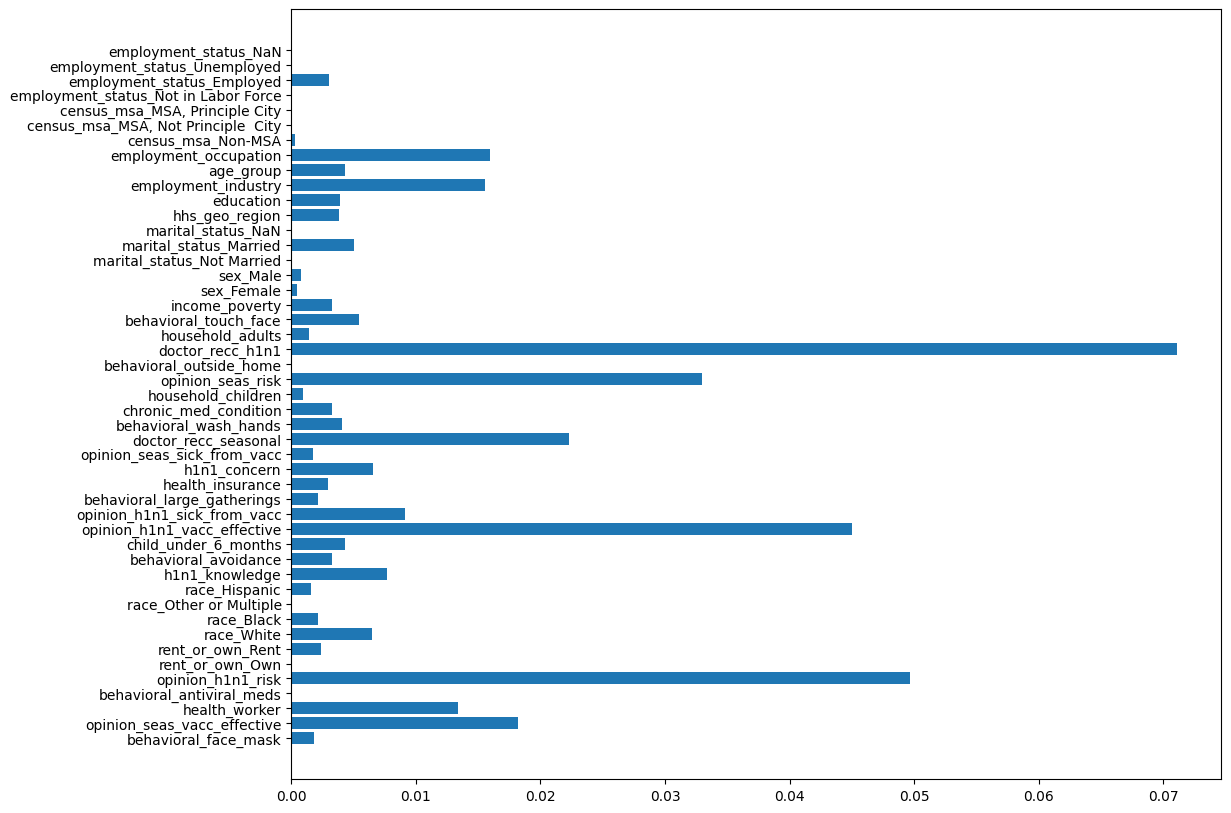

In [43]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')

# df_train_processed = data_preparation_pipeline.fit_transform(df_train_for_preprocess)
fs.fit(df_train_for_preprocess, labels_train['h1n1_vaccine'])

for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()

#### Classifiers

In [44]:
fs_model_pipes_to_evaluate = dict()

##### Logistic Regressor

In [45]:
model = LogisticRegression(C=1, n_jobs=-1, verbose=False)
model_name = 'Simple Logit Regressor on selected Features'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
fs_model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### SVM

In [46]:
model = SVC(verbose=False, max_iter=50000)
model_name = 'Simple SVM classifier on selected Features'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
fs_model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### Random Forest

In [47]:
model = RandomForestClassifier(n_jobs=-1, verbose=False)
model_name = 'Simple Random Forest on selected Features'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
fs_model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### XGBoost

In [48]:
model_name = 'Guessed HyperParams XGBClassifier on selected Features'
model = XGBClassifier(objective = 'binary:logistic',
                     n_estimators = 1000,
                     learning_rate = 0.01,
                     n_jobs = -1) # ,
                    #  tree_method = 'gpu_hist')
fit_params = {
    # model_name + '__early_stopping_rounds' : 30,
    # model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    # model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
fs_model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### LightGBM

In [49]:
model_name = 'Guessed HyperParams LightGBM on selected Features'
model = LGBMClassifier(n_estimators=1000, n_jobs = -1, objective = 'binary')
fit_params = {
    # model_name + '__early_stopping_rounds' : 30,
    # model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    # model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

pipeline = Pipeline([
    ('preprocess', data_preparation_pipeline),
    ('Standardize Column Names', LGBMCategoryNameEncoder()),
    (model_name, model)
])
fs_model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

#### And for the results:

In [50]:
set(features_df_new.columns.values)

{'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'opinion_h1n1_risk',
 'opinion_seas_risk'}

In [54]:
df_train_with_FS_for_clf = df_train[set(features_df_new.columns.values) | FEATURES_TO_CLASSIFY_BY]

labels_train_for_clf = labels_train['h1n1_vaccine']

In [55]:
CROSS_VALIDATOR = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

def evaluate_model_pipelines(model_pipelines):
  train_cv_scoreboard = pd.DataFrame()
  val_cv_scoreboard = pd.DataFrame()

  for name, (model_pipeline, fit_params) in tqdm(model_pipelines.items()):
    print('\n###########################################################################')
    print('# Model type: {}'.format(name))
    print('###########################################################################')
    
    # Train the model
    fit_start = perf_counter()
    cv_scores = cross_validate(model_pipeline, df_train_with_FS_for_clf, labels_train_for_clf,
                            fit_params = fit_params,
                            cv=CROSS_VALIDATOR,
                            n_jobs = -1,
                            scoring='roc_auc',
                            return_train_score=True)
    fit_end = perf_counter()

    print()
    fit_time = report_fit_time(fit_start, fit_end)
    
    # plot_model_performance(model_history)
    # train_predictions = model_pipeline.predict(df_train_for_clf)
    # val_predictions = model_pipeline.predict(df_val_for_clf)
    # test_predictions = model_pipeline.predict(df_test_for_clf)

    train_cv_scoreboard[name] = cv_scores['train_score']
    val_cv_scoreboard[name] = cv_scores['test_score']
        
    # scores = {
    #     'Training' : cv_scores['train_score'].mean(),
    #     'Validation' : cv_scores['test_score'].mean()
    #     # 'Test' : accuracy_score(labels_test_for_clf, test_predictions)
    #     }

    # for dataset_name, score in scores.items():
      # print ("%s auc: %0.5f " % (dataset_name, score))  
    # print(f'''Training:
    # Mean Score: {cv_scores['train_score'].mean()}
    # Score Standad Deviation: {cv_scores['train_score'].std()}''')

    # print(f'''Validation:
    # Mean Score: {cv_scores['test_score'].mean()}
    # Score Standad Deviation: {cv_scores['test_score'].std()}''')

    if is_model_fame_worthy(val_cv_scoreboard[name]):
      model_pipeline.fit(df_train_for_clf, labels_train_for_clf, **fit_params)

      global best_model_so_far
      best_model_so_far = {
          'name' : name, # Name of the model
          'pipeline_and_params' : (model_pipeline, fit_params), # A tuple containing a sklearn.Pipeline object and a parameters dict
          'scores' : {
              'train' : train_cv_scoreboard[name],
              'validation' : val_cv_scoreboard[name]
          }, # The cv scores of the model
          'time' : fit_time # Training time in seconds
          }
      dict_of_fame[name] = scores

  print()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print('@ Best models roundup')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  for name, score in dict_of_fame.items():
    print(f'Name: {name}\n Scores: {score}')

  train_cv_scoreboard['Best So Far'] = best_model_so_far['scores']['train']
  val_cv_scoreboard['Best So Far'] = best_model_so_far['scores']['validation']
  
  return train_cv_scoreboard, val_cv_scoreboard

fs_train_cv_scoreboard, fs_val_cv_scoreboard = evaluate_model_pipelines(fs_model_pipes_to_evaluate)

  0%|          | 0/5 [00:00<?, ?it/s]


###########################################################################
# Model type: Simple Logit Regressor on selected Features
###########################################################################


 20%|██        | 1/5 [00:05<00:23,  5.90s/it]


Cross Validation time: 0 hours, 0 minutes, 5 seconds

###########################################################################
# Model type: Simple SVM classifier on selected Features
###########################################################################


 40%|████      | 2/5 [02:30<04:22, 87.34s/it]


Cross Validation time: 0 hours, 2 minutes, 24 seconds

###########################################################################
# Model type: Simple Random Forest on selected Features
###########################################################################


 60%|██████    | 3/5 [02:36<01:40, 50.27s/it]


Cross Validation time: 0 hours, 0 minutes, 6 seconds

###########################################################################
# Model type: Guessed HyperParams XGBClassifier on selected Features
###########################################################################


 80%|████████  | 4/5 [03:56<01:02, 62.22s/it]


Cross Validation time: 0 hours, 1 minutes, 20 seconds

###########################################################################
# Model type: Guessed HyperParams LightGBM on selected Features
###########################################################################


100%|██████████| 5/5 [04:07<00:00, 49.53s/it]


Cross Validation time: 0 hours, 0 minutes, 10 seconds

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@ Best models roundup
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Name: Guessed HyperParams XGBClassifier
 Scores: {'train': 0    0.907312
1    0.907068
2    0.908829
3    0.908840
4    0.907546
Name: Guessed HyperParams XGBClassifier, dtype: float64, 'validation': 0    0.837579
1    0.843970
2    0.835417
3    0.842397
4    0.843620
Name: Guessed HyperParams XGBClassifier, dtype: float64}


In [72]:
overall_train_cv_scoreboard = pd.concat([overall_train_cv_scoreboard, fs_train_cv_scoreboard])
overall_val_cv_scoreboard = pd.concat([overall_val_cv_scoreboard, fs_val_cv_scoreboard])

In [ ]:
# best_model_so_far = {
#           'name' : 'Guessed HyperParams XGBClassifier', # Name of the model
#           'pipeline_and_params' : best_model_so_far['pipeline_and_params'], # A tuple containing a sklearn.Pipeline object and a parameters dict
#           'scores' : {
#               'train' : train_cv_scoreboard['Guessed HyperParams XGBClassifier'],
#               'validation' : val_cv_scoreboard['Guessed HyperParams XGBClassifier']
#           }, # The cv scores of the model
#           'time' : best_model_so_far['time'] # Training time in seconds
#           }

<AxesSubplot:title={'center':'validation scores'}>

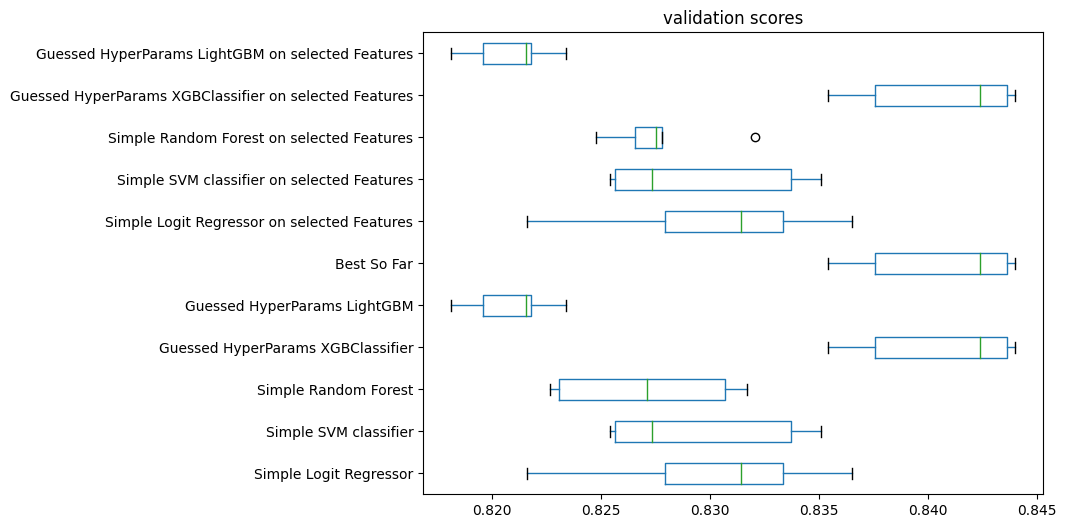

In [73]:
overall_val_cv_scoreboard.plot(kind='box', title='validation scores', figsize = (8,6), vert=False)

In [74]:
save_model_pipeline_and_info(best_model_so_far, file_name='best_model_so_far.pickle')
best_model_so_far

{'name': 'Guessed HyperParams XGBClassifier',
 'pipeline_and_params': (Pipeline(steps=[('preprocess',
                   Pipeline(steps=[('Impute',
                                    DataFrameMapper(df_out=True, drop_cols=[],
                                                    features=[(['behavioral_large_gatherings'],
                                                               TransformerPipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent'))]),
                                                               {}),
                                                              (['behavioral_antiviral_meds'],
                                                               TransformerPipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent'))]),
                             

## Trying the same simple models as is on seasonal vaccines

In [75]:
overall_train_cv_scoreboard = pd.DataFrame()
overall_val_cv_scoreboard = pd.DataFrame()

dict_of_fame = {}
global best_model_so_far
best_model_so_far = None

In [76]:
float_features_to_classify_by = float_features_to_preprocess
string_features_to_classify_by = string_features_to_preprocess

FEATURES_TO_CLASSIFY_BY = float_features_to_classify_by | string_features_to_classify_by
df_train_for_clf = df_train[FEATURES_TO_CLASSIFY_BY]
labels_train_for_clf = labels_train['seasonal_vaccine']


In [77]:
labels_train_for_clf.head(1)

respondent_id
0    0
Name: seasonal_vaccine, dtype: int64

In [78]:
CROSS_VALIDATOR = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

def evaluate_model_pipelines(model_pipelines):
  train_cv_scoreboard = pd.DataFrame()
  val_cv_scoreboard = pd.DataFrame()

  for name, (model_pipeline, fit_params) in tqdm(model_pipelines.items()):
    print('\n###########################################################################')
    print('# Model type: {}'.format(name))
    print('###########################################################################')
    
    # Train the model
    fit_start = perf_counter()
    cv_scores = cross_validate(model_pipeline, df_train_for_clf, labels_train_for_clf,
                            fit_params = fit_params,
                            cv=CROSS_VALIDATOR,
                            n_jobs = -1,
                            scoring='roc_auc',
                            return_train_score=True)
    fit_end = perf_counter()

    print()
    fit_time = report_fit_time(fit_start, fit_end)
    
    # plot_model_performance(model_history)
    # train_predictions = model_pipeline.predict(df_train_for_clf)
    # val_predictions = model_pipeline.predict(df_val_for_clf)
    # test_predictions = model_pipeline.predict(df_test_for_clf)

    train_cv_scoreboard[name] = cv_scores['train_score']
    val_cv_scoreboard[name] = cv_scores['test_score']
        
    # scores = {
    #     'Training' : cv_scores['train_score'].mean(),
    #     'Validation' : cv_scores['test_score'].mean()
    #     # 'Test' : accuracy_score(labels_test_for_clf, test_predictions)
    #     }

    # for dataset_name, score in scores.items():
      # print ("%s auc: %0.5f " % (dataset_name, score))  
    # print(f'''Training:
    # Mean Score: {cv_scores['train_score'].mean()}
    # Score Standad Deviation: {cv_scores['train_score'].std()}''')

    # print(f'''Validation:
    # Mean Score: {cv_scores['test_score'].mean()}
    # Score Standad Deviation: {cv_scores['test_score'].std()}''')

    if is_model_fame_worthy(val_cv_scoreboard[name]):
      model_pipeline.fit(df_train_for_clf, labels_train_for_clf, **fit_params)

      global best_model_so_far
      best_model_so_far = {
          # Name of the model
          'name' : name, 
          # A tuple containing a sklearn.Pipeline object and a parameters dict
          'pipeline_and_params' : (model_pipeline, fit_params), 
           # The cv scores of the model
          'scores' : {
              'train' : train_cv_scoreboard[name],
              'validation' : val_cv_scoreboard[name]
          },
          # Training time in seconds
          'time' : fit_time 
          }
      dict_of_fame[name] = best_model_so_far['scores']

  print()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print('@ Best models roundup')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  for name, score in dict_of_fame.items():
    print(f'Name: {name}\n Scores: {score}')

  train_cv_scoreboard['Best So Far'] = best_model_so_far['scores']['train']
  val_cv_scoreboard['Best So Far'] = best_model_so_far['scores']['validation']
  
  return train_cv_scoreboard, val_cv_scoreboard

train_cv_scoreboard, val_cv_scoreboard = evaluate_model_pipelines(model_pipes_to_evaluate)

  0%|          | 0/5 [00:00<?, ?it/s]


###########################################################################
# Model type: Simple Logit Regressor
###########################################################################

Cross Validation time: 0 hours, 0 minutes, 3 seconds


 20%|██        | 1/5 [00:07<00:28,  7.07s/it]


###########################################################################
# Model type: Simple SVM classifier
###########################################################################


 40%|████      | 2/5 [02:29<04:20, 86.80s/it]


Cross Validation time: 0 hours, 2 minutes, 22 seconds

###########################################################################
# Model type: Simple Random Forest
###########################################################################


 60%|██████    | 3/5 [02:37<01:41, 50.95s/it]


Cross Validation time: 0 hours, 0 minutes, 8 seconds

###########################################################################
# Model type: Guessed HyperParams XGBClassifier
###########################################################################

Cross Validation time: 0 hours, 1 minutes, 40 seconds


 80%|████████  | 4/5 [04:43<01:20, 80.38s/it]


###########################################################################
# Model type: Guessed HyperParams LightGBM
###########################################################################


100%|██████████| 5/5 [04:56<00:00, 59.28s/it]


Cross Validation time: 0 hours, 0 minutes, 12 seconds

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@ Best models roundup
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Name: Simple Logit Regressor
 Scores: {'train': 0    0.848175
1    0.848571
2    0.850671
3    0.849792
4    0.849902
Name: Simple Logit Regressor, dtype: float64, 'validation': 0    0.854996
1    0.854169
2    0.845875
3    0.849286
4    0.849182
Name: Simple Logit Regressor, dtype: float64}
Name: Guessed HyperParams XGBClassifier
 Scores: {'train': 0    0.907028
1    0.906261
2    0.909168
3    0.909196
4    0.907976
Name: Guessed HyperParams XGBClassifier, dtype: float64, 'validation': 0    0.864932
1    0.865112
2    0.856329
3    0.857886
4    0.862738
Name: Guessed HyperParams XGBClassifier, dtype: float64}


In [79]:
overall_train_cv_scoreboard = pd.concat([overall_train_cv_scoreboard, train_cv_scoreboard])
overall_val_cv_scoreboard = pd.concat([overall_val_cv_scoreboard, val_cv_scoreboard])

In [80]:
# best_model_so_far = {
#           'name' : 'Guessed HyperParams XGBClassifier', # Name of the model
#           'pipeline_and_params' : best_model_so_far['pipeline_and_params'], # A tuple containing a sklearn.Pipeline object and a parameters dict
#           'scores' : {
#               'train' : train_cv_scoreboard['Guessed HyperParams XGBClassifier'],
#               'validation' : val_cv_scoreboard['Guessed HyperParams XGBClassifier']
#           }, # The cv scores of the model
#           'time' : best_model_so_far['time'] # Training time in seconds
#           }

<AxesSubplot:title={'center':'validation scores'}>

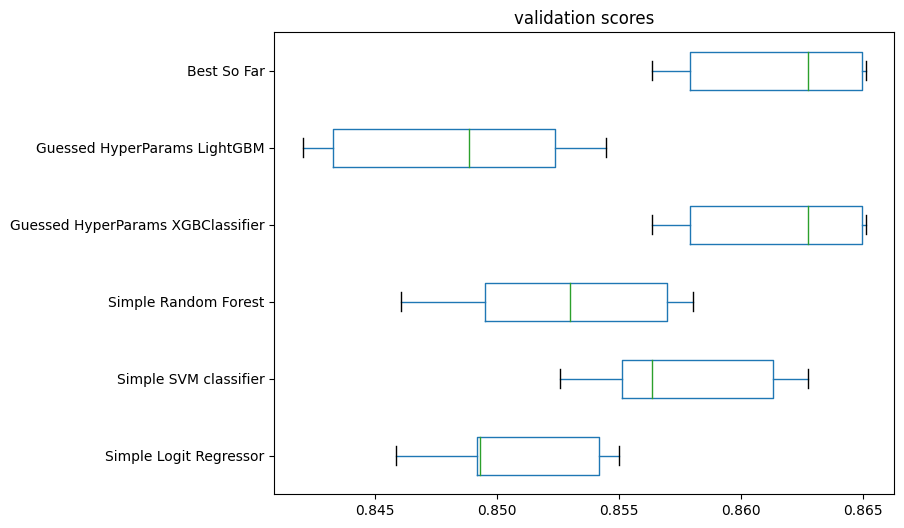

In [81]:
overall_val_cv_scoreboard.plot(kind='box', title='validation scores', figsize = (8,6), vert=False)

In [82]:
save_model_pipeline_and_info(best_model_so_far, file_name='seasonal_best_model_so_far.pickle')
best_model_so_far

{'name': 'Guessed HyperParams XGBClassifier',
 'pipeline_and_params': (Pipeline(steps=[('preprocess',
                   Pipeline(steps=[('Impute',
                                    DataFrameMapper(df_out=True, drop_cols=[],
                                                    features=[(['behavioral_face_mask'],
                                                               [SimpleImputer(strategy='most_frequent')],
                                                               {}),
                                                              (['opinion_seas_vacc_effective'],
                                                               [SimpleImputer(strategy='most_frequent')],
                                                               {}),
                                                              (['health_worker'],
                                                               [SimpleImputer(strategy='most_frequent')],
                                                    

# Testing the model's performance on the test set

For starters, let's see how the submission format looks

In [2]:
df_submission = pd.read_csv("submission_format.csv", 
                            index_col="respondent_id")
df_submission                    

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
...,...,...
53410,0.5,0.7
53411,0.5,0.7
53412,0.5,0.7


It's a csv of probabilities for each class

Let's create our submission's csv

In [6]:
df_test = pd.read_csv("test_set_features.csv", index_col="respondent_id")

best_h1n1_model_so_far = get_model_pipeline_and_info(file_name=os.path.join(f'h1n1_best_model_so_far.pickle'))
best_seasonal_model_so_far = get_model_pipeline_and_info(file_name=os.path.join(f'seasonal_best_model_so_far.pickle'))
# best_model_so_far

First, i'll peek at the format of the model results 

In [9]:
best_h1n1_model_so_far['pipeline_and_params'][0].predict_proba(df_test)

array([0.06915827, 0.03779046, 0.52076024, ..., 0.10582604, 0.03051772,
       0.45446256], dtype=float32)

And make sure we have the correct rows in the correct order

In [11]:
np.testing.assert_array_equal(df_test.index.values, 
                              df_submission.index.values)

Looks good! 
Let's get some results and wish for the best :)

In [13]:
df_test_results = pd.DataFrame(index=df_test.index)
df_test_results['h1n1_vaccine'] = best_h1n1_model_so_far['pipeline_and_params'][0].predict_proba(df_test)[:, 1]
df_test_results['seasonal_vaccine'] = best_seasonal_model_so_far['pipeline_and_params'][0].predict_proba(df_test)[:, 1]

df_test_results

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.069158,0.186340
26708,0.037790,0.042525
26709,0.520760,0.781454
26710,0.710526,0.895794
26711,0.244549,0.519195
...,...,...
53410,0.406843,0.603161
53411,0.148749,0.270229
53412,0.105826,0.148929


In [14]:
df_test_results.to_csv('test_labels_2022-12-23.csv')

We got a score of 0.8425 AUC ROC

Not too shabby for a first try 😎